In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import trimesh

scene = trimesh.Scene()

In [2]:
import my_code.diffusion_training.data_loading as data_loading

dataset = data_loading.get_val_dataset(
    'FAUST_orig', 'train', 32, canonicalize_fmap='both'
    )[1]

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Loading base dataset: 100%|███████████████████████████████████████████████████████████████████████| 80/80 [00:14<00:00,  5.63it/s]


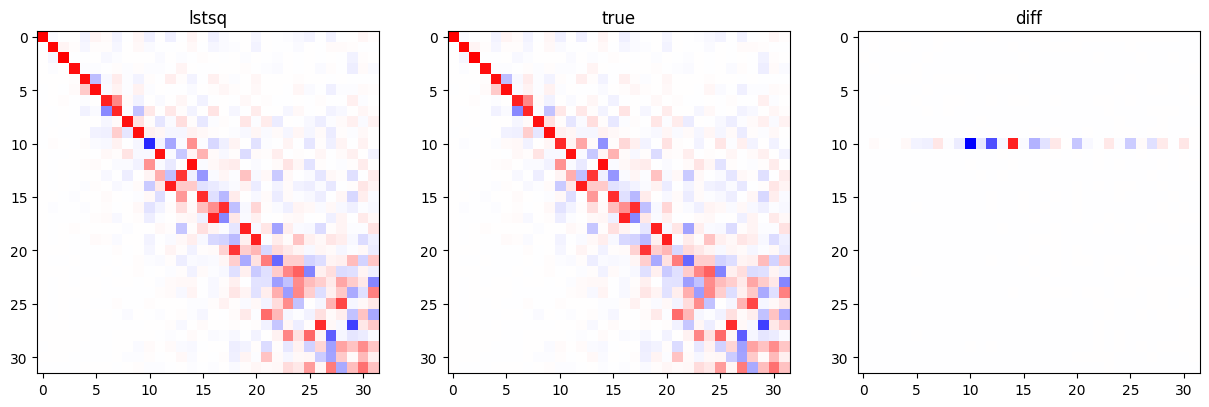

In [3]:
data_32 = dataset[32]

evecs_first = data_32['first']['evecs'].clone()
evecs_second = data_32['second']['evecs'].clone()

corr_first = data_32['first']['corr'].clone()
corr_second = data_32['second']['corr'].clone()

C_gt_xy = data_32['second']['C_gt_xy'].clone()


evecs_second[:, 10] *= -1


C_gt_xy_lstsq = torch.linalg.lstsq(
    evecs_second[corr_second],
    evecs_first[corr_first]
    ).solution.unsqueeze(0)

# C_gt_xy_lstsq[0, 10, :] *= -1

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(C_gt_xy_lstsq[0][:32, :32], vmin=-1, vmax=1, cmap='bwr')
axs[0].set_title('lstsq')

axs[1].imshow(C_gt_xy[0][:32, :32], vmin=-1, vmax=1, cmap='bwr')
axs[1].set_title('true')

axs[2].imshow(C_gt_xy_lstsq[0][:32, :32] - C_gt_xy[0][:32, :32], vmin=-1, vmax=1, cmap='bwr')
axs[2].set_title('diff')


plt.show()

In [5]:
def plot_Cxy(figure, axis, Cxy_plt, title, min_dim, max_dim, show_grid, show_colorbar):
    
    axis_plot = axis.imshow(Cxy_plt[min_dim:max_dim, min_dim:max_dim], cmap='bwr', vmin=-1, vmax=1)
    
    if show_colorbar:
        figure.colorbar(axis_plot, ax=axis)
    
    axis.set_title(f'{title}: {min_dim}-{max_dim}')

    axis.set_xticks(np.arange(-0.5, max_dim - min_dim, 1.0))
    axis.set_yticks(np.arange(-0.5, max_dim - min_dim, 1.0)) 
    
    if show_grid:
        axis.grid(which='both')    
    
    axis.set_xticklabels([])
    axis.set_yticklabels([])

tensor([0.7030, 0.9370, 0.8337, 0.8580, 0.8542, 1.2476, 1.3675, 0.3386, 1.0680,
        0.9882, 1.1557, 1.1798, 1.4739, 0.2541, 0.7681, 0.5722, 1.3104, 0.5867,
        0.5186, 0.6824, 1.4994, 0.2882, 0.2671, 0.4005, 0.8972, 1.4335, 0.6456,
        0.1265, 0.3096, 0.6061, 0.2568, 1.9244])
tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False,  True, False, False,
        False, False])
N different signs: tensor(4)


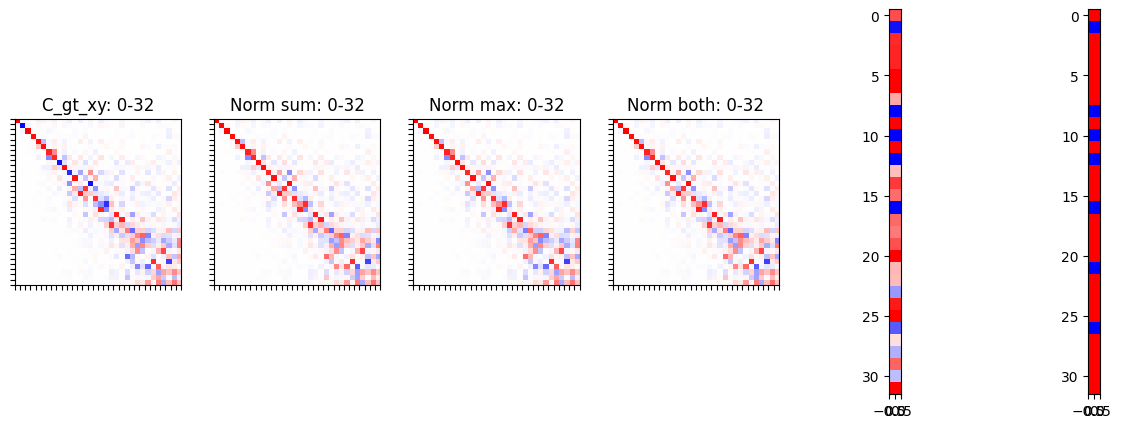

In [5]:
l = 0
h = 32

C_gt_xy = data_32['second']['C_gt_xy'][:,l:h,l:h].clone()

# option 1: take the sign of the sum of the row
# sum_per_row = torch.sum(C_gt_xy[0], dim=1).unsqueeze(1)
# signs_sum_per_row = torch.sign(sum_per_row)

sum_per_row = torch.sum(C_gt_xy, dim=2).transpose(0, 1)
signs_sum_per_row = torch.sign(sum_per_row)
# print(sum_per_row.shape)

# option 2: take the sign of the max element of the row
arg_max_in_row = torch.argmax(torch.abs(C_gt_xy), dim=2)
sign_max_in_row = torch.sign(
    C_gt_xy[torch.arange(C_gt_xy.shape[0]), torch.arange(C_gt_xy.shape[1]), arg_max_in_row]
    ).transpose(0, 1)


# option 3: for rows that have abs sum < 0.2, use the max
abs_sum = torch.abs(sum_per_row).flatten()
mask = abs_sum < 0.2

print(abs_sum)
print(mask)

signs_both = torch.ones_like(signs_sum_per_row)
signs_both[mask] = signs_both[mask] * sign_max_in_row[mask]
signs_both[~mask] = signs_both[~mask] * signs_sum_per_row[~mask]

# update the functional map
C_xy_norm_sum = C_gt_xy * signs_sum_per_row
C_xy_norm_max = C_gt_xy * sign_max_in_row
C_xy_norm_both = C_gt_xy * signs_both

# print(C_gt_xy, C_xy_norm_sum)

print('N different signs:', torch.sum(signs_sum_per_row != sign_max_in_row))


# plot the results

fig, axs = plt.subplots(1, 6, figsize=(15, 5))

h = h - l
l = 0

plot_Cxy(fig, axs[0], C_gt_xy[0], 'C_gt_xy', l, h, show_grid=False, show_colorbar=False)
plot_Cxy(fig, axs[1], C_xy_norm_sum[0], 'Norm sum', l, h, show_grid=False, show_colorbar=False)
plot_Cxy(fig, axs[2], C_xy_norm_max[0], 'Norm max', l, h, show_grid=False, show_colorbar=False)
plot_Cxy(fig, axs[3], C_xy_norm_both[0], 'Norm both', l, h, show_grid=False, show_colorbar=False)


axs[4].imshow(sum_per_row[l:h], cmap='bwr', vmin=-1, vmax=1)
axs[5].imshow(sign_max_in_row[l:h], cmap='bwr', vmin=-1, vmax=1)

plt.show()

In [43]:
print((C_gt_xy[0, -7, :] * (C_gt_xy[0, -7, :].abs() > 0.2).int()).sum())

tensor(-0.6085)


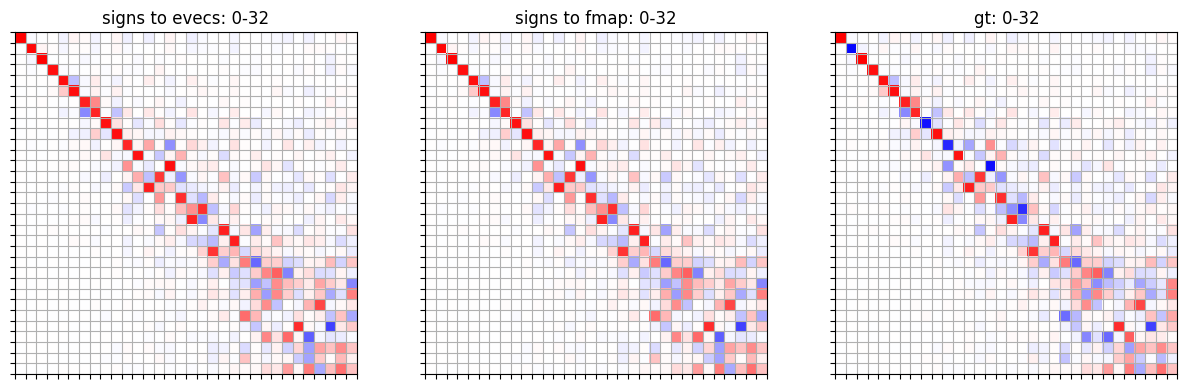

In [6]:
evecs_first = data_32['first']['evecs'][:,l:h].clone()
evecs_second = data_32['second']['evecs'][:,l:h].clone()

corr_first = data_32['first']['corr'].clone()
corr_second = data_32['second']['corr'].clone()

# C_gt_xy = data_32['second']['C_gt_xy'][0,l:h,l:h].clone()

C_gt_xy = torch.linalg.lstsq(
    evecs_second[corr_second],
    evecs_first[corr_first]
    ).solution


evecs_second = evecs_second[:, :32] * signs_sum_per_row[:, 0]


C_gt_xy_norm = torch.linalg.lstsq(
    evecs_second[corr_second],
    evecs_first[corr_first]
    ).solution

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
plot_Cxy(fig, axs[0], C_gt_xy_norm, 'signs to evecs', l, h, show_grid=True, show_colorbar=False)
plot_Cxy(fig, axs[1], C_xy_norm_sum[0], 'signs to fmap', l, h, show_grid=True, show_colorbar=False)
plot_Cxy(fig, axs[2], C_gt_xy, 'gt', l, h, show_grid=True, show_colorbar=False)

plt.show()


In [16]:
import importlib

importlib.reload(preprocessing)

<module 'my_code.datasets.preprocessing' from '/home/s94zalek_hpc/shape_matching/my_code/datasets/preprocessing.py'>

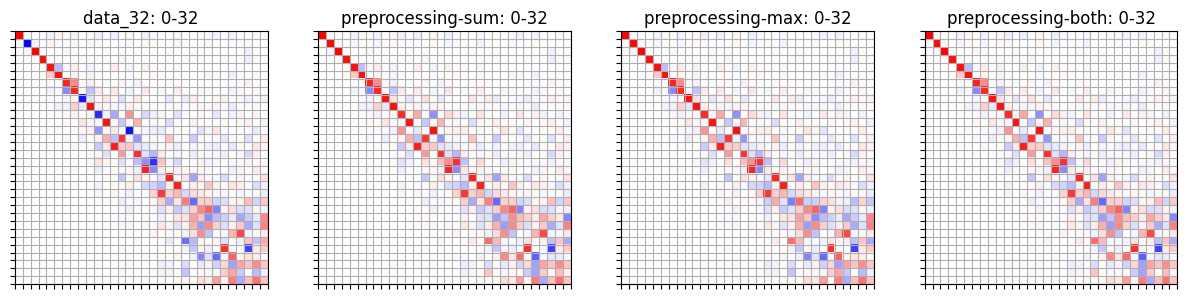

In [8]:
import my_code.datasets.preprocessing as preprocessing

C_gt_xy_prepr_both, _ = preprocessing.canonicalize_fmap(
    canon_type='both',
    data_payload = data_32,
)
C_gt_xy_prepr_sum, _ = preprocessing.canonicalize_fmap(
    canon_type='sum',
    data_payload = data_32,
)
C_gt_xy_prepr_max, _ = preprocessing.canonicalize_fmap(
    canon_type='max',
    data_payload = data_32,
)

l = 0
h = 32

fig, axs = plt.subplots(1, 4, figsize=(15, 5))
plot_Cxy(fig, axs[0], data_32['second']['C_gt_xy_uncan'][0], 'data_32', l, h, show_grid=True, show_colorbar=False)
plot_Cxy(fig, axs[1], C_gt_xy_prepr_sum[0], 'preprocessing-sum', l, h, show_grid=True, show_colorbar=False)
plot_Cxy(fig, axs[2], C_gt_xy_prepr_max[0], 'preprocessing-max', l, h, show_grid=True, show_colorbar=False)
plot_Cxy(fig, axs[3], C_gt_xy_prepr_both[0], 'preprocessing-both', l, h, show_grid=True, show_colorbar=False)

plt.show()

In [15]:
list(payload_preprocessed['second'].keys())

['name',
 'verts',
 'faces',
 'evecs',
 'evecs_trans',
 'evals',
 'mass',
 'L',
 'corr',
 'id',
 'C_gt_xy',
 'C_gt_xy_uncan',
 'evecs_uncan']

## Canonicalized vs uncanonicalized

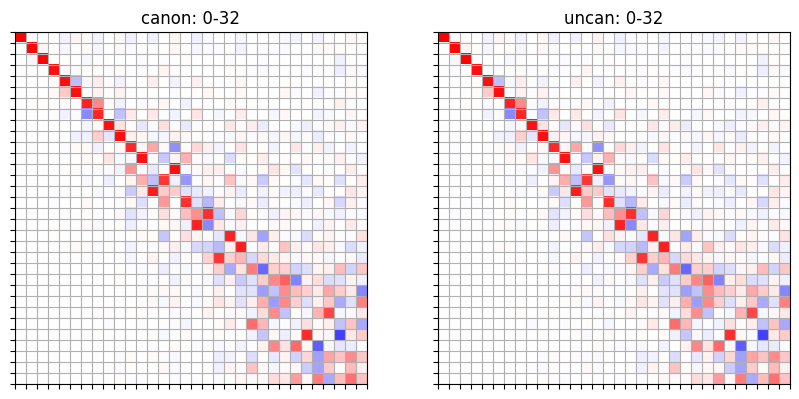

In [10]:
l = 0
h = 32

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

plot_Cxy(fig, axs[0], dataset[32]['second']['C_gt_xy'][0], 'canon', l, h, show_grid=True, show_colorbar=False)
plot_Cxy(fig, axs[1], dataset[32]['second']['C_gt_xy_uncan'][0], 'uncan', l, h, show_grid=True, show_colorbar=False)

plt.show()

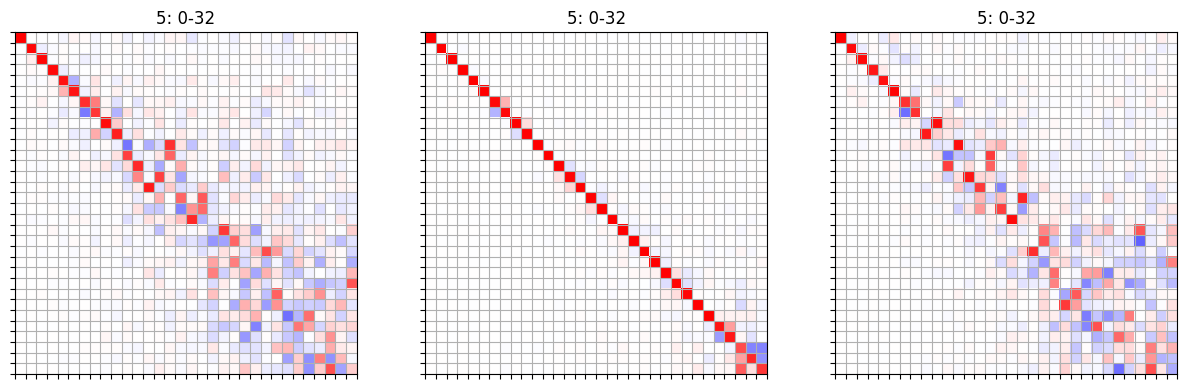

In [8]:
l = 0
h = 32

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
# plot_Cxy(fig, axs[0], C_gt_xy_norm, 'signs to evecs', l, h, show_grid=True, show_colorbar=False)

plot_Cxy(fig, axs[0], dataset[27]['second']['C_gt_xy'][0], '5', l, h, show_grid=True, show_colorbar=False)
plot_Cxy(fig, axs[1], dataset[5]['second']['C_gt_xy'][0], '5', l, h, show_grid=True, show_colorbar=False)
plot_Cxy(fig, axs[2], dataset[14]['second']['C_gt_xy'][0], '5', l, h, show_grid=True, show_colorbar=False)

plt.show()

In [ ]:
# modify cannicalization: use max if abs of sum is < 0.1
# look at resulting fmaps

## No need to switch the signs on evecs_trans

In [7]:
(evecs_second @ data_32['second']['evecs_trans'][:32, :]).abs().sum(), \
    (data_32['second']['evecs'][:, :32] @ data_32['second']['evecs_trans'][:32, :]).abs().sum()

(tensor(32009.1250), tensor(17429.7969))

In [8]:
(data_32['second']['evecs_trans'][:32, :] @ evecs_second).abs().sum(), \
    (data_32['second']['evecs_trans'][:32, :] @ data_32['second']['evecs'][:, :32]).abs().sum()

(tensor(32.0000), tensor(32.0000))

In [144]:
evecs_trans_second = data_32['second']['evecs_trans'][:32, :].clone() * signs_sum_per_row
(evecs_second @ evecs_trans_second).abs().sum()

tensor(0.0004)